In [82]:
#强制关闭GPU
#对于深度2-5和隐藏单元数32-128较小的时候，CPU速度快。
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [83]:
import numpy as np
import tensorflow as tf
import h5py
import random
import time
import matplotlib.pyplot as plt
tf.reset_default_graph()
tf.test.is_gpu_available()

False

In [84]:
from scipy.io import loadmat#用于加载mat文件
data_m= loadmat(".\\6train_data_withoutCorrelation_20.mat")#mat-->dict字典。
print(data_m.keys())#其中有很多key，注意找自己数据所在的那个
train_data = data_m["train_data_withoutCorrelation"]
X1=[]
X2=[]
Y=[]
for i in range(1440):
    d=train_data[0][i]
    d=np.transpose(d)
    x1=d[2:][:][::-1]

    x2=d[0:2][::-1]

    y=d[0][-1]
    X1.append(x1)
    X2.append(x2)
    Y.append(y)
data_x1=np.array(X1)
data_x2=np.array(X2)
data_y=np.expand_dims(np.array(Y),axis=1)

##################分配训练测试集with sklearn Time Series Cross Validation
num=list(range(data_x1.shape[0]))
# print(num)
array=np.array(num)

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4)#n_splits折交叉验证,n_splits折为n_splits+1份数据
list_train=[]
list_test=[]
for train, test in tscv.split(array):
    list_train.append(train)
    list_test.append(test)
#     print("%s %s" % (train, test))
# print(list_train)
# print(list_test)
#**********注意这部分要做3次*****************！！！！
num2=list_train[3] #3折交叉验证取0,1,2 
num1=list_test[3]  #3折交叉验证取0,1,2

# num2=list(range(0,144*8,1))
# num1=list(range(144*8,144*10,1))
print(num2)
print(num1)

#####################################
x1_train=data_x1[num2]
x2_train=data_x2[num2]
y_train=data_y[num2]
print('x1_train',np.shape(x1_train))
print('x2_train',np.shape(x2_train))
print('y_train',np.shape(y_train))
x1_test=data_x1[num1]
x2_test=data_x2[num1]
y_test=data_y[num1]
print('x1_test',np.shape(x1_test))
print('x2_test',np.shape(x2_test))
print('y_test',np.shape(y_test))
#生成批次
train_queue = tf.train.slice_input_producer([x1_train,x2_train,y_train],shuffle=None)
val_queue = tf.train.slice_input_producer([x1_test,x2_test,y_test],shuffle=None)

# batch_xt1,batch_xt2,batch_yt=tf.train.shuffle_batch(train_queue,batch_size=36,capacity=2000,min_after_dequeue=150)
# batch_xv1,batch_xv2,batch_yv=tf.train.shuffle_batch(val_queue,batch_size=36,capacity=2000,min_after_dequeue=150)
batch_xt1,batch_xt2,batch_yt=tf.train.batch(train_queue,batch_size=1152,capacity=1440)
batch_xv1,batch_xv2,batch_yv=tf.train.batch(val_queue,batch_size=288,capacity=1440)
print('batch_xv1',np.shape(batch_xv1))
print('batch_xv2',np.shape(batch_xv2))
print('batch_yv',np.shape(batch_yv))

dict_keys(['__header__', '__version__', '__globals__', 'train_data_withoutCorrelation'])
[   0    1    2 ... 1149 1150 1151]
[1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165
 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179
 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193
 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207
 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221
 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235
 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249
 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263
 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277
 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291
 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305
 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319
 1320 1321 1322 1323 13

In [85]:
seq_length = batch_xt1.shape[1]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = batch_xt1.shape[0]  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!
de_length=2
output_dim = 1
# input_dim = 16  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 32 # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 4  # Number of stacked recurrent cells, on the neural depth axis. 
alpha=0.5#损失loss1函数占比
alpha_w=0.01#所有可以训练的参数的正则占比# L2 regularization of weights - avoids overfitting
# Optmizer: 
learning_rate = 0.005  # Small lr helps not to diverge during training. 
interval = 1 # show loss and acc every interval step
wholestep = 1 # 多少步运行完一个完整测试集，=测试集长度除批长度
max_iters = 500  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update

In [86]:
with tf.variable_scope('encoder'):

    # Encoder: inputs
    enc_inp1 = tf.placeholder(tf.float32, shape=(None,5,54), name="inp1")
    enc_inp2 = tf.placeholder(tf.float32, shape=(None,2,54), name="inp2")
    print('enc_inp1',np.shape(enc_inp1)) 
    print('enc_inp2',np.shape(enc_inp2))
    print('enc_inp2[:,0,:] 是recent data，enc_inp2[:,1,:]是future data')

    # Decoder: expected output
    expected_output = tf.placeholder(tf.float32, shape=(None,1), name="expected_output")
    pharse=tf.placeholder(tf.bool,name='training')

    # encoder cell 
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
#             cells.append(tf.contrib.rnn.GRUCell(hidden_dim))
            cells.append(tf.nn.rnn_cell.BasicLSTMCell(hidden_dim))
    cell = tf.contrib.rnn.MultiRNNCell(cells)

    enc_outputs, enc_memory = tf.nn.dynamic_rnn(cell,enc_inp1,dtype=tf.float32)
    print('enc_outputs',np.shape(enc_outputs))
    
with tf.variable_scope('decoder'):  
    decells=[]
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
#             decells.append(tf.contrib.rnn.GRUCell(hidden_dim))
            decells.append(tf.nn.rnn_cell.BasicLSTMCell(hidden_dim))
    decell = tf.contrib.rnn.MultiRNNCell(decells)
    
    dec_state=enc_memory
    
    dec_inp=enc_inp2[:,1,-6:]
    dec_outputs=[]
    outs=[]
    #reshape expected_sparse_output
    w_h = tf.Variable(tf.random_normal([hidden_dim,6]))
    b_h = tf.Variable(tf.random_normal([6]))
    
#     dec_inputs=[tf.matmul(expected_sparse_output[:,i,:],w_h)+b_h for i in range(seq_length)]
    for time_step in range(de_length):
        if time_step>0:
            tf.get_variable_scope().reuse_variables()
        (dec_output,dec_state)=decell(dec_inp,dec_state)
        out1=tf.matmul(dec_output,w_h)+b_h
        if pharse==True:
            dec_inp=enc_inp2[:,time_step+1,-6:]
#     print('训练时dec_inp',np.shape(dec_inp[:,1,:]))   
        else:
            dec_inp=out1
#     print('测试时dec_inp',只输出out1)            
        outs.append(out1)
        dec_outputs.append(dec_output)

    print('dec_state',np.shape(dec_state))
#     (dec_output,dec_state)=decell(dec_inp,dec_state)
    
#     out1=tf.matmul(dec_output,w_h)+b_h

#     outs.append(out1)
#     dec_outputs.append(dec_output)
    
    # reshape seq2seq输出 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # 最终输出
    pre_output1=outs[0]
    pre_output2=tf.matmul(dec_outputs[-1],w_out)+b_out
    
    print(pre_output1.shape)
    print(pre_output2.shape)

enc_inp1 (?, 5, 54)
enc_inp2 (?, 2, 54)
enc_inp2[:,0,:] 是recent data，enc_inp2[:,1,:]是future data
enc_outputs (?, 5, 32)
dec_state (4, 2)
(?, 6)
(?, 1)


In [87]:
with tf.variable_scope('Loss'):
    # L2 loss
#     output_loss1 = tf.reduce_sum(tf.square(enc_inp2[:,1,:] - pre_output1)) #loss1 目标点之前到现在的点的MSE
#     output_loss2 = tf.reduce_sum(tf.square(expected_output - pre_output2)) #loss2 目标点的MSE
    
    output_loss1=tf.sqrt(tf.reduce_mean(tf.squared_difference(enc_inp2[:,1,-7:-1], pre_output1)))   #loss2 目标点的RMSE
    output_loss2=tf.sqrt(tf.reduce_mean(tf.squared_difference(expected_output, pre_output2)))   #loss2 目标点的RMSE

    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    
    loss = alpha*output_loss1+output_loss2+alpha_w*reg_loss       
#     loss = output_loss + lambda_l2_reg * reg_loss
    loss = output_loss2+alpha_w*reg_loss
#     loss = output_loss2
    tf.summary.scalar('loss',loss)

with tf.variable_scope('Optimizer'):
#     optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    #使用梯度下降法
#     optimizer = tf.train.GradientDescentOptimizer(0.5)
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
    
    train_op = optimizer.minimize(loss)
    merged_summary = tf.summary.merge_all()
    
# 加一些评价指标
with tf.variable_scope('ACC'): 
    if expected_output==0:
        acc = 1
    else:
        acc = 1-tf.reduce_mean(tf.sqrt(tf.square(expected_output-pre_output2))/tf.sqrt(tf.square(expected_output)),axis=(0,1))
    tf.summary.scalar('ACC',acc)
    
with tf.variable_scope('RMSE'):
    rmse=tf.sqrt(tf.reduce_mean(tf.squared_difference(pre_output2, expected_output)))
    tf.summary.scalar('RMSE',rmse) 

# from sklearn.metrics import r2_score
with tf.variable_scope('R_square'):
    unexplained_error = tf.reduce_sum(tf.square(expected_output - pre_output2))
    total_error = tf.reduce_sum(tf.square(expected_output - tf.reduce_mean(expected_output, axis=0)))
    r_square = 1. - tf.div(unexplained_error, total_error)
#     r_square=r2_score(pre_output2, expected_output)
    tf.summary.scalar('R_square',r_square) 

In [88]:
min_loss=1e10
sess=tf.Session()
# train_writer=tf.summary.FileWriter('graph/train/',sess.graph)
# test_writer = tf.summary.FileWriter('graph/test/', sess.graph)
# saver=tf.train.Saver(max_to_keep=3)

init_op = tf.global_variables_initializer()
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord)
# max_acc=0.5
min_loss=10000
t1=time.time()
# 按间隔定义方式：fig_accuracy = np.zeros(int(np.ceil(iteration / interval)))
fig_loss_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_acc_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_rmse_train = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_r_square_train = np.zeros(int(np.ceil((max_iters+1) / interval)))

fig_loss_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_acc_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_rmse_test = np.zeros(int(np.ceil((max_iters+1) / interval)))
fig_r_square_test = np.zeros(int(np.ceil((max_iters+1) / interval)))

for training_itr in range(max_iters):
    x1, x2, y = sess.run([batch_xt1,batch_xt2,batch_yt])
    feed_dict1 = {enc_inp1: x1}
    feed_dict1.update({enc_inp2:x2})
    feed_dict1.update({expected_output: y})
    feed_dict1.update({pharse:True})
#     _, loss1,acc1,summaries1 = sess.run([train_op, loss,acc,merged_summary], feed_dict1)
    _, loss1,acc1,rmse1,r_square1,summaries1 = sess.run([train_op,loss,acc,rmse,r_square,merged_summary], feed_dict1)
#     train_writer.add_summary(summaries1, training_itr)

    if (training_itr+1) % interval==0:
        tt=time.time()        
    # 分 interval个batch 迭代
        test_acc = 0.0
        test_loss = 0.0
        test_rmse = 0.0
        test_r_square = 0.0
        
        N = wholestep
        for j in range(N):
            test_x1,test_x2,test_y=sess.run([batch_xv1,batch_xv2,batch_yv])
            feed_dict2 = {enc_inp1:test_x1}
            feed_dict2.update({enc_inp2:test_x2})
            feed_dict2.update({expected_output: test_y})
            feed_dict2.update({pharse:False})
        
#             loss2,acc2,summaries2 = sess.run([loss,acc,merged_summary], feed_dict2)
            loss2,acc2,rmse2,r_square2,summaries2 = sess.run([loss,acc,rmse,r_square,merged_summary], feed_dict2) 
            test_acc+=acc2
            test_loss+=loss2
            test_rmse+=rmse2
            test_r_square+=r_square2
           
        print('step: {} time:{}'.format(training_itr+1,time.time()-tt))
        print('Train: loss: {} acc: {} rmse: {} r_square: {}'.format(loss1,acc1,rmse1,r_square1))
        print('Val:   loss: {} acc: {} rmse: {} r_square: {}'.format(loss2,acc2,rmse2,r_square2))

        fig_loss_train[int(np.ceil((training_itr+1)/ interval))]=loss1
        fig_acc_train[int(np.ceil((training_itr+1)/ interval))]=acc1
        fig_rmse_train[int(np.ceil((training_itr+1)/ interval))]=rmse1
        fig_r_square_train[int(np.ceil((training_itr+1)/ interval))]=r_square1

        fig_loss_test[int(np.ceil((training_itr+1)/ interval))]=test_loss/N
        fig_acc_test[int(np.ceil((training_itr+1)/ interval))]=test_acc/N
        fig_rmse_test[int(np.ceil((training_itr+1)/ interval))]=test_rmse/N
        fig_r_square_test[int(np.ceil((training_itr+1)/ interval))]=test_r_square/N
        
#         if test_loss/N<min_loss:
#             min_loss=test_loss/N
        if loss1<min_loss:
            min_loss=loss1
            test_acc_aver=test_acc/N
#             test_loss_aver=test_loss/N
            test_rmse_aver=test_rmse/N
            test_r_square_aver=test_r_square/N
            train_acc_aver=acc1
#             train_loss_aver=min_loss
            train_rmse_aver=rmse1
            train_r_square_aver=r_square1
            fig_prediction=sess.run(pre_output2, feed_dict={enc_inp1: test_x1,enc_inp2:test_x2})
            fig_val=test_y
#         test_writer.add_summary(summaries2, training_itr)
#         if loss1 < min_loss:
#             min_loss=loss1
#             saver.save(sess=sess, save_path='model/model.ckpt',global_step=(training_itr + 1))

total_time=time.time()-t1
coord.request_stop()
coord.join(threads)
sess.close()
print('final time:',total_time)
print('test 1-MAPE:',test_acc_aver)

step: 1 time:0.15595006942749023
Train: loss: 10.698781967163086 acc: 0.2597268223762512 rmse: 6.047946929931641 r_square: -1.9384849071502686
Val:   loss: 6.516124725341797 acc: 0.5459116697311401 rmse: 2.104036569595337 r_square: -0.30988407135009766
step: 2 time:0.004987955093383789
Train: loss: 9.966484069824219 acc: 0.327106237411499 rmse: 5.55439567565918 r_square: -1.4784557819366455
Val:   loss: 6.022101879119873 acc: 0.34790873527526855 rmse: 1.8230786323547363 r_square: 0.016584336757659912
step: 3 time:0.0
Train: loss: 9.07440185546875 acc: 0.36573344469070435 rmse: 4.875378131866455 r_square: -0.9095200300216675
Val:   loss: 6.207850456237793 acc: -0.2462906837463379 rmse: 2.194922685623169 r_square: -0.4254918098449707
step: 4 time:0.0
Train: loss: 8.058181762695312 acc: 0.31432831287384033 rmse: 4.045255184173584 r_square: -0.314617395401001
Val:   loss: 7.4552459716796875 acc: -1.1356315612792969 rmse: 3.6044559478759766 r_square: -2.844197988510132
step: 5 time:0.0
Trai

step: 35 time:0.015622138977050781
Train: loss: 2.8918662071228027 acc: 0.7149344682693481 rmse: 1.1083931922912598 r_square: 0.9013049602508545
Val:   loss: 3.7675294876098633 acc: -0.13441979885101318 rmse: 2.0048060417175293 r_square: -0.18924415111541748
step: 36 time:0.017109155654907227
Train: loss: 2.9724175930023193 acc: 0.6304209232330322 rmse: 1.2096941471099854 r_square: 0.8824402093887329
Val:   loss: 3.622925281524658 acc: -0.04393184185028076 rmse: 1.8797446489334106 r_square: -0.04549992084503174
step: 37 time:0.006006479263305664
Train: loss: 2.9241983890533447 acc: 0.6715589761734009 rmse: 1.1810178756713867 r_square: 0.8879477977752686
Val:   loss: 3.335916757583618 acc: 0.15890544652938843 rmse: 1.6093915700912476 r_square: 0.23361021280288696
step: 38 time:0.0
Train: loss: 2.8376264572143555 acc: 0.7386122345924377 rmse: 1.1111013889312744 r_square: 0.900822103023529
Val:   loss: 3.230564594268799 acc: 0.23012685775756836 rmse: 1.5169881582260132 r_square: 0.3190885

step: 70 time:0.01562047004699707
Train: loss: 1.9075303077697754 acc: 0.89375901222229 rmse: 0.5297780632972717 r_square: 0.9774526357650757
Val:   loss: 1.85444974899292 acc: 0.7413886189460754 rmse: 0.4841966927051544 r_square: 0.9306302666664124
step: 71 time:0.0049860477447509766
Train: loss: 1.850914478302002 acc: 0.8991876244544983 rmse: 0.4806613624095917 r_square: 0.9814396500587463
Val:   loss: 1.88948655128479 acc: 0.7079155445098877 rmse: 0.5239576697349548 r_square: 0.9187695980072021
step: 72 time:0.015628814697265625
Train: loss: 1.9014503955841064 acc: 0.8788998126983643 rmse: 0.5359216332435608 r_square: 0.9769266843795776
Val:   loss: 1.837507963180542 acc: 0.7263284921646118 rmse: 0.4804537892341614 r_square: 0.9316986203193665
step: 73 time:0.015622138977050781
Train: loss: 1.7794604301452637 acc: 0.899703860282898 rmse: 0.42240622639656067 r_square: 0.9856659770011902
Val:   loss: 1.8579351902008057 acc: 0.7421908378601074 rmse: 0.5115973353385925 r_square: 0.92255

step: 104 time:0.015621423721313477
Train: loss: 1.585652470588684 acc: 0.9061563611030579 rmse: 0.43670907616615295 r_square: 0.9846788048744202
Val:   loss: 1.5027250051498413 acc: 0.7927401661872864 rmse: 0.35972657799720764 r_square: 0.9617112278938293
step: 105 time:0.0
Train: loss: 1.5128484964370728 acc: 0.9195721745491028 rmse: 0.3698500096797943 r_square: 0.9890109896659851
Val:   loss: 1.525056004524231 acc: 0.8098355531692505 rmse: 0.3904258906841278 r_square: 0.9548971652984619
step: 106 time:0.0
Train: loss: 1.613921046257019 acc: 0.9090023040771484 rmse: 0.47929105162620544 r_square: 0.9815453290939331
Val:   loss: 1.4962728023529053 acc: 0.8130971789360046 rmse: 0.3669959306716919 r_square: 0.9601480960845947
step: 107 time:0.01562356948852539
Train: loss: 1.5526009798049927 acc: 0.9178596138954163 rmse: 0.4233240783214569 r_square: 0.9856036305427551
Val:   loss: 1.516859531402588 acc: 0.7809481620788574 rmse: 0.3902261555194855 r_square: 0.9549433588981628
step: 108 ti

step: 139 time:0.015620708465576172
Train: loss: 1.3542821407318115 acc: 0.9270756840705872 rmse: 0.3729320764541626 r_square: 0.9888270497322083
Val:   loss: 1.3018585443496704 acc: 0.8175296187400818 rmse: 0.32171574234962463 r_square: 0.9693753719329834
step: 140 time:0.0
Train: loss: 1.3545254468917847 acc: 0.9180018901824951 rmse: 0.3743826746940613 r_square: 0.9887399673461914
Val:   loss: 1.2803540229797363 acc: 0.8242141604423523 rmse: 0.3042284846305847 r_square: 0.9726141691207886
step: 141 time:0.015620946884155273
Train: loss: 1.3095201253890991 acc: 0.9261671900749207 rmse: 0.3333945572376251 r_square: 0.991070568561554
Val:   loss: 1.3016729354858398 acc: 0.8385570049285889 rmse: 0.33180877566337585 r_square: 0.967423677444458
step: 142 time:0.0
Train: loss: 1.3753074407577515 acc: 0.9225420355796814 rmse: 0.4054432511329651 r_square: 0.986794114112854
Val:   loss: 1.2798221111297607 acc: 0.8419007658958435 rmse: 0.3134278655052185 r_square: 0.9709329009056091
step: 143 t

step: 173 time:0.015619516372680664
Train: loss: 1.172755479812622 acc: 0.9313375353813171 rmse: 0.3061915934085846 r_square: 0.9924682974815369
Val:   loss: 1.1821452379226685 acc: 0.8423498272895813 rmse: 0.3211539685726166 r_square: 0.9694822430610657
step: 174 time:0.0
Train: loss: 1.2514729499816895 acc: 0.9244973063468933 rmse: 0.3904816806316376 r_square: 0.987750768661499
Val:   loss: 1.1666266918182373 acc: 0.8412384390830994 rmse: 0.3086763620376587 r_square: 0.9718075394630432
step: 175 time:0.015621185302734375
Train: loss: 1.2004573345184326 acc: 0.9334657192230225 rmse: 0.34250712394714355 r_square: 0.9905757308006287
Val:   loss: 1.194000244140625 acc: 0.8075964450836182 rmse: 0.3366807997226715 r_square: 0.9664599895477295
step: 176 time:0.0
Train: loss: 1.230019211769104 acc: 0.9206072092056274 rmse: 0.37269964814186096 r_square: 0.9888409972190857
Val:   loss: 1.1606038808822632 acc: 0.8215773105621338 rmse: 0.3063376843929291 r_square: 0.9722331166267395
step: 177 ti

step: 208 time:0.0
Train: loss: 1.109107494354248 acc: 0.9328643679618835 rmse: 0.3330846428871155 r_square: 0.9910871386528015
Val:   loss: 1.0311578512191772 acc: 0.8495825529098511 rmse: 0.25789883732795715 r_square: 0.9803199768066406
step: 209 time:0.0
Train: loss: 1.0627164840698242 acc: 0.9371659755706787 rmse: 0.28945744037628174 r_square: 0.9932690262794495
Val:   loss: 1.0628886222839355 acc: 0.8552090525627136 rmse: 0.29466521739959717 r_square: 0.9743088483810425
step: 210 time:0.0
Train: loss: 1.1325937509536743 acc: 0.9319970011711121 rmse: 0.36437052488327026 r_square: 0.9893341660499573
Val:   loss: 1.0538651943206787 acc: 0.8518080115318298 rmse: 0.2880447208881378 r_square: 0.9754502773284912
step: 211 time:0.015621185302734375
Train: loss: 1.0939295291900635 acc: 0.9376903176307678 rmse: 0.3281090557575226 r_square: 0.9913514256477356
Val:   loss: 1.0661965608596802 acc: 0.8244270086288452 rmse: 0.3003506064414978 r_square: 0.9733078479766846
step: 212 time:0.0
Train

step: 243 time:0.020945072174072266
Train: loss: 1.0215609073638916 acc: 0.9384212493896484 rmse: 0.32094234228134155 r_square: 0.9917251467704773
Val:   loss: 0.9679067134857178 acc: 0.8448998332023621 rmse: 0.26679208874702454 r_square: 0.9789393544197083
step: 244 time:0.01562190055847168
Train: loss: 1.010979175567627 acc: 0.9319068193435669 rmse: 0.3098644018173218 r_square: 0.9922865033149719
Val:   loss: 0.9546139240264893 acc: 0.8490179181098938 rmse: 0.25545480847358704 r_square: 0.9806912541389465
step: 245 time:0.0
Train: loss: 0.9809685349464417 acc: 0.9373230934143066 rmse: 0.28180938959121704 r_square: 0.9936200380325317
Val:   loss: 0.971550464630127 acc: 0.8645350933074951 rmse: 0.2764075696468353 r_square: 0.9773938655853271
step: 246 time:0.0
Train: loss: 1.0297675132751465 acc: 0.9360516667366028 rmse: 0.33462458848953247 r_square: 0.9910045266151428
Val:   loss: 0.9562743902206421 acc: 0.8678841590881348 rmse: 0.2626282274723053 r_square: 0.9795916080474854
step: 24

step: 278 time:0.0
Train: loss: 0.9520061016082764 acc: 0.9392634034156799 rmse: 0.30804869532585144 r_square: 0.9923766255378723
Val:   loss: 0.8942890167236328 acc: 0.8732524514198303 rmse: 0.25142911076545715 r_square: 0.9812949895858765
step: 279 time:0.0
Train: loss: 0.9132769107818604 acc: 0.9446192383766174 rmse: 0.2704170048236847 r_square: 0.9941254258155823
Val:   loss: 0.8834637403488159 acc: 0.8648214340209961 rmse: 0.23965303599834442 r_square: 0.9830061197280884
step: 280 time:0.006734371185302734
Train: loss: 0.9672368764877319 acc: 0.9346539974212646 rmse: 0.323426216840744 r_square: 0.991596519947052
Val:   loss: 0.8659598231315613 acc: 0.8694273233413696 rmse: 0.2240862250328064 r_square: 0.9851421117782593
step: 281 time:0.015621662139892578
Train: loss: 0.9114230871200562 acc: 0.941927969455719 rmse: 0.2695493698120117 r_square: 0.9941630959510803
Val:   loss: 0.8988280296325684 acc: 0.8722824454307556 rmse: 0.2610666751861572 r_square: 0.9798335433006287
step: 282 

step: 312 time:0.0
Train: loss: 0.9392238855361938 acc: 0.9285559058189392 rmse: 0.3375152051448822 r_square: 0.9908484816551208
Val:   loss: 0.826560378074646 acc: 0.8703915476799011 rmse: 0.2264060229063034 r_square: 0.9848328828811646
step: 313 time:0.0
Train: loss: 0.8816320300102234 acc: 0.9393431544303894 rmse: 0.281477689743042 r_square: 0.9936350584030151
Val:   loss: 0.8576481938362122 acc: 0.8776499032974243 rmse: 0.26127153635025024 r_square: 0.9798018932342529
step: 314 time:0.006506681442260742
Train: loss: 0.9257696270942688 acc: 0.9388961791992188 rmse: 0.3293929696083069 r_square: 0.9912835955619812
Val:   loss: 0.8612158894538879 acc: 0.8766759634017944 rmse: 0.26593685150146484 r_square: 0.9790741205215454
step: 315 time:0.010007381439208984
Train: loss: 0.9244924783706665 acc: 0.9381343722343445 rmse: 0.32921352982521057 r_square: 0.9912931323051453
Val:   loss: 0.8044137954711914 acc: 0.8745876550674438 rmse: 0.20790442824363708 r_square: 0.9872105121612549
step: 31

step: 346 time:0.01562047004699707
Train: loss: 0.9365379810333252 acc: 0.9348055124282837 rmse: 0.373733252286911 r_square: 0.9887790083885193
Val:   loss: 0.8370504379272461 acc: 0.8779819011688232 rmse: 0.27508118748664856 r_square: 0.9776102900505066
step: 347 time:0.0
Train: loss: 0.9366830587387085 acc: 0.9327380061149597 rmse: 0.37471383810043335 r_square: 0.9887200593948364
Val:   loss: 0.7515906095504761 acc: 0.8846237659454346 rmse: 0.18810071051120758 r_square: 0.9895309805870056
step: 348 time:0.0
Train: loss: 0.757134199142456 acc: 0.9593958258628845 rmse: 0.19364424049854279 r_square: 0.9969875812530518
Val:   loss: 0.7591904401779175 acc: 0.8818318843841553 rmse: 0.19643065333366394 r_square: 0.9885832071304321
step: 349 time:0.015626192092895508
Train: loss: 0.7959926128387451 acc: 0.9517138600349426 rmse: 0.23323288559913635 r_square: 0.9956299662590027
Val:   loss: 0.7772822380065918 acc: 0.8863193988800049 rmse: 0.2176896631717682 r_square: 0.9859782457351685
step: 3

step: 380 time:0.021852970123291016
Train: loss: 0.7200134992599487 acc: 0.9627678394317627 rmse: 0.18436244130134583 r_square: 0.9972694516181946
Val:   loss: 0.7222514152526855 acc: 0.8877476453781128 rmse: 0.1872357875108719 r_square: 0.9896270036697388
step: 381 time:0.015622615814208984
Train: loss: 0.7518360614776611 acc: 0.9523202776908875 rmse: 0.21682040393352509 r_square: 0.9962233304977417
Val:   loss: 0.7330401539802551 acc: 0.8904242515563965 rmse: 0.2008724808692932 r_square: 0.9880610108375549
step: 382 time:0.015621423721313477
Train: loss: 0.7904236316680908 acc: 0.950421929359436 rmse: 0.25825589895248413 r_square: 0.9946419596672058
Val:   loss: 0.712567925453186 acc: 0.8919186592102051 rmse: 0.1809125542640686 r_square: 0.9903157949447632
step: 383 time:0.015621185302734375
Train: loss: 0.7153579592704773 acc: 0.9622333645820618 rmse: 0.18370266258716583 r_square: 0.9972889423370361
Val:   loss: 0.7834932208061218 acc: 0.8619906306266785 rmse: 0.2502775192260742 r_s

step: 415 time:0.01562190055847168
Train: loss: 0.7757761478424072 acc: 0.9504020810127258 rmse: 0.2679690420627594 r_square: 0.9942313432693481
Val:   loss: 0.7058744430541992 acc: 0.8858444094657898 rmse: 0.19628159701824188 r_square: 0.988600492477417
step: 416 time:0.0
Train: loss: 0.7658695578575134 acc: 0.9471909403800964 rmse: 0.2562767267227173 r_square: 0.9947237372398376
Val:   loss: 0.6882566213607788 acc: 0.8924763798713684 rmse: 0.17950010299682617 r_square: 0.9904664158821106
step: 417 time:0.0
Train: loss: 0.7299490571022034 acc: 0.9550371170043945 rmse: 0.22119253873825073 r_square: 0.9960694909095764
Val:   loss: 0.7435291409492493 acc: 0.887571394443512 rmse: 0.2378595471382141 r_square: 0.9832595586776733
step: 418 time:0.015621662139892578
Train: loss: 0.8128999471664429 acc: 0.9425854682922363 rmse: 0.3072302043437958 r_square: 0.9924170970916748
Val:   loss: 0.722230076789856 acc: 0.891843855381012 rmse: 0.2171834111213684 r_square: 0.986043393611908
step: 419 tim

step: 448 time:0.015627384185791016
Train: loss: 0.7866628170013428 acc: 0.9398815631866455 rmse: 0.2962532341480255 r_square: 0.9929492473602295
Val:   loss: 0.698279857635498 acc: 0.881116509437561 rmse: 0.2087763547897339 r_square: 0.9871029853820801
step: 449 time:0.0
Train: loss: 0.7476025819778442 acc: 0.9436622858047485 rmse: 0.2580990791320801 r_square: 0.9946484565734863
Val:   loss: 0.6966309547424316 acc: 0.8883029222488403 rmse: 0.21038322150707245 r_square: 0.986903727054596
step: 450 time:0.0
Train: loss: 0.7632425427436829 acc: 0.9479426741600037 rmse: 0.2769947946071625 r_square: 0.9938361644744873
Val:   loss: 0.699663519859314 acc: 0.8859266042709351 rmse: 0.21395912766456604 r_square: 0.9864547252655029
step: 451 time:0.012004375457763672
Train: loss: 0.7392175197601318 acc: 0.9512028098106384 rmse: 0.2535131275653839 r_square: 0.9948369264602661
Val:   loss: 0.6924343109130859 acc: 0.8764493465423584 rmse: 0.2048482894897461 r_square: 0.9875837564468384
step: 452 ti

step: 482 time:0.0
Train: loss: 0.7524486780166626 acc: 0.9486067295074463 rmse: 0.28183606266975403 r_square: 0.9936188459396362
Val:   loss: 0.68059903383255 acc: 0.8936483860015869 rmse: 0.2102426141500473 r_square: 0.9869211912155151
step: 483 time:0.0
Train: loss: 0.7101432085037231 acc: 0.954865038394928 rmse: 0.23978689312934875 r_square: 0.9953808784484863
Val:   loss: 0.6747170090675354 acc: 0.8834709525108337 rmse: 0.20229162275791168 r_square: 0.9878917336463928
step: 484 time:0.0
Train: loss: 0.7481733560562134 acc: 0.9447687268257141 rmse: 0.27574798464775085 r_square: 0.9938915371894836
Val:   loss: 0.6606415510177612 acc: 0.887412428855896 rmse: 0.1888643503189087 r_square: 0.9894458055496216
step: 485 time:0.015625953674316406
Train: loss: 0.7031246423721313 acc: 0.9503411054611206 rmse: 0.2313474714756012 r_square: 0.9957002997398376
Val:   loss: 0.6970123052597046 acc: 0.8846649527549744 rmse: 0.22815528512001038 r_square: 0.9845976233482361
step: 486 time:0.015627622

In [89]:
#**********注意这部分要做10次，取平均值
print('final time:',total_time)
print('epoch size:',max_iters*wholestep)
print('Training evaluation:',train_acc_aver,train_rmse_aver,train_r_square_aver) #10000代结果
print('Testing evaluation:',test_acc_aver,test_rmse_aver,test_r_square_aver) #10000代结果

final time: 48.21601581573486
epoch size: 500
Training evaluation: 0.95765185 0.20222254 0.9967148
Testing evaluation: 0.8862407207489014 0.22991859912872314 0.9843586683273315


In [90]:
for i in range(len(fig_prediction)):
    print(fig_prediction[i][0])

7.3707414
7.0012426
6.5400014
7.5272484
7.0967045
6.882181
6.188965
8.258536
7.17521
8.345383
6.8363333
7.730582
7.837665
7.211669
7.3625746
7.075715
6.7860975
6.326912
6.371638
6.1794295
5.823981
6.0032496
6.4595823
5.068808
5.84877
6.324626
5.873897
5.8694296
5.6462655
5.3471336
5.949234
5.7617965
5.706309
6.126812
6.13688
4.982909
6.112873
5.9086018
5.948862
3.7797785
2.422281
2.1889772
2.2151556
2.194951
2.4219365
2.469554
2.0966623
2.0760632
2.4609542
2.8727622
1.8710941
1.5229156
1.7146144
1.3682754
0.9787148
0.9223311
1.1195452
1.0359764
1.4569294
1.1195422
1.8171251
1.6132327
1.6705801
1.7020907
1.7385447
2.3712544
2.1897764
2.7984095
5.8118763
4.9140215
1.1028512
4.511393
2.7510781
0.80714494
3.5521803
3.7844915
4.4792323
3.7532558
5.169153
4.30162
5.1974454
3.5350566
4.248216
4.934879
5.145274
4.83876
4.4761925
4.7926865
3.9467354
4.0684705
3.7888517
4.2414007
3.471624
3.3561606
2.724042
2.7259088
2.2984982
2.7401257
2.1851983
2.2906308
1.9804958
1.5619831
1.3118038
1.4491681

Text(0, 0.5, 'Loss')

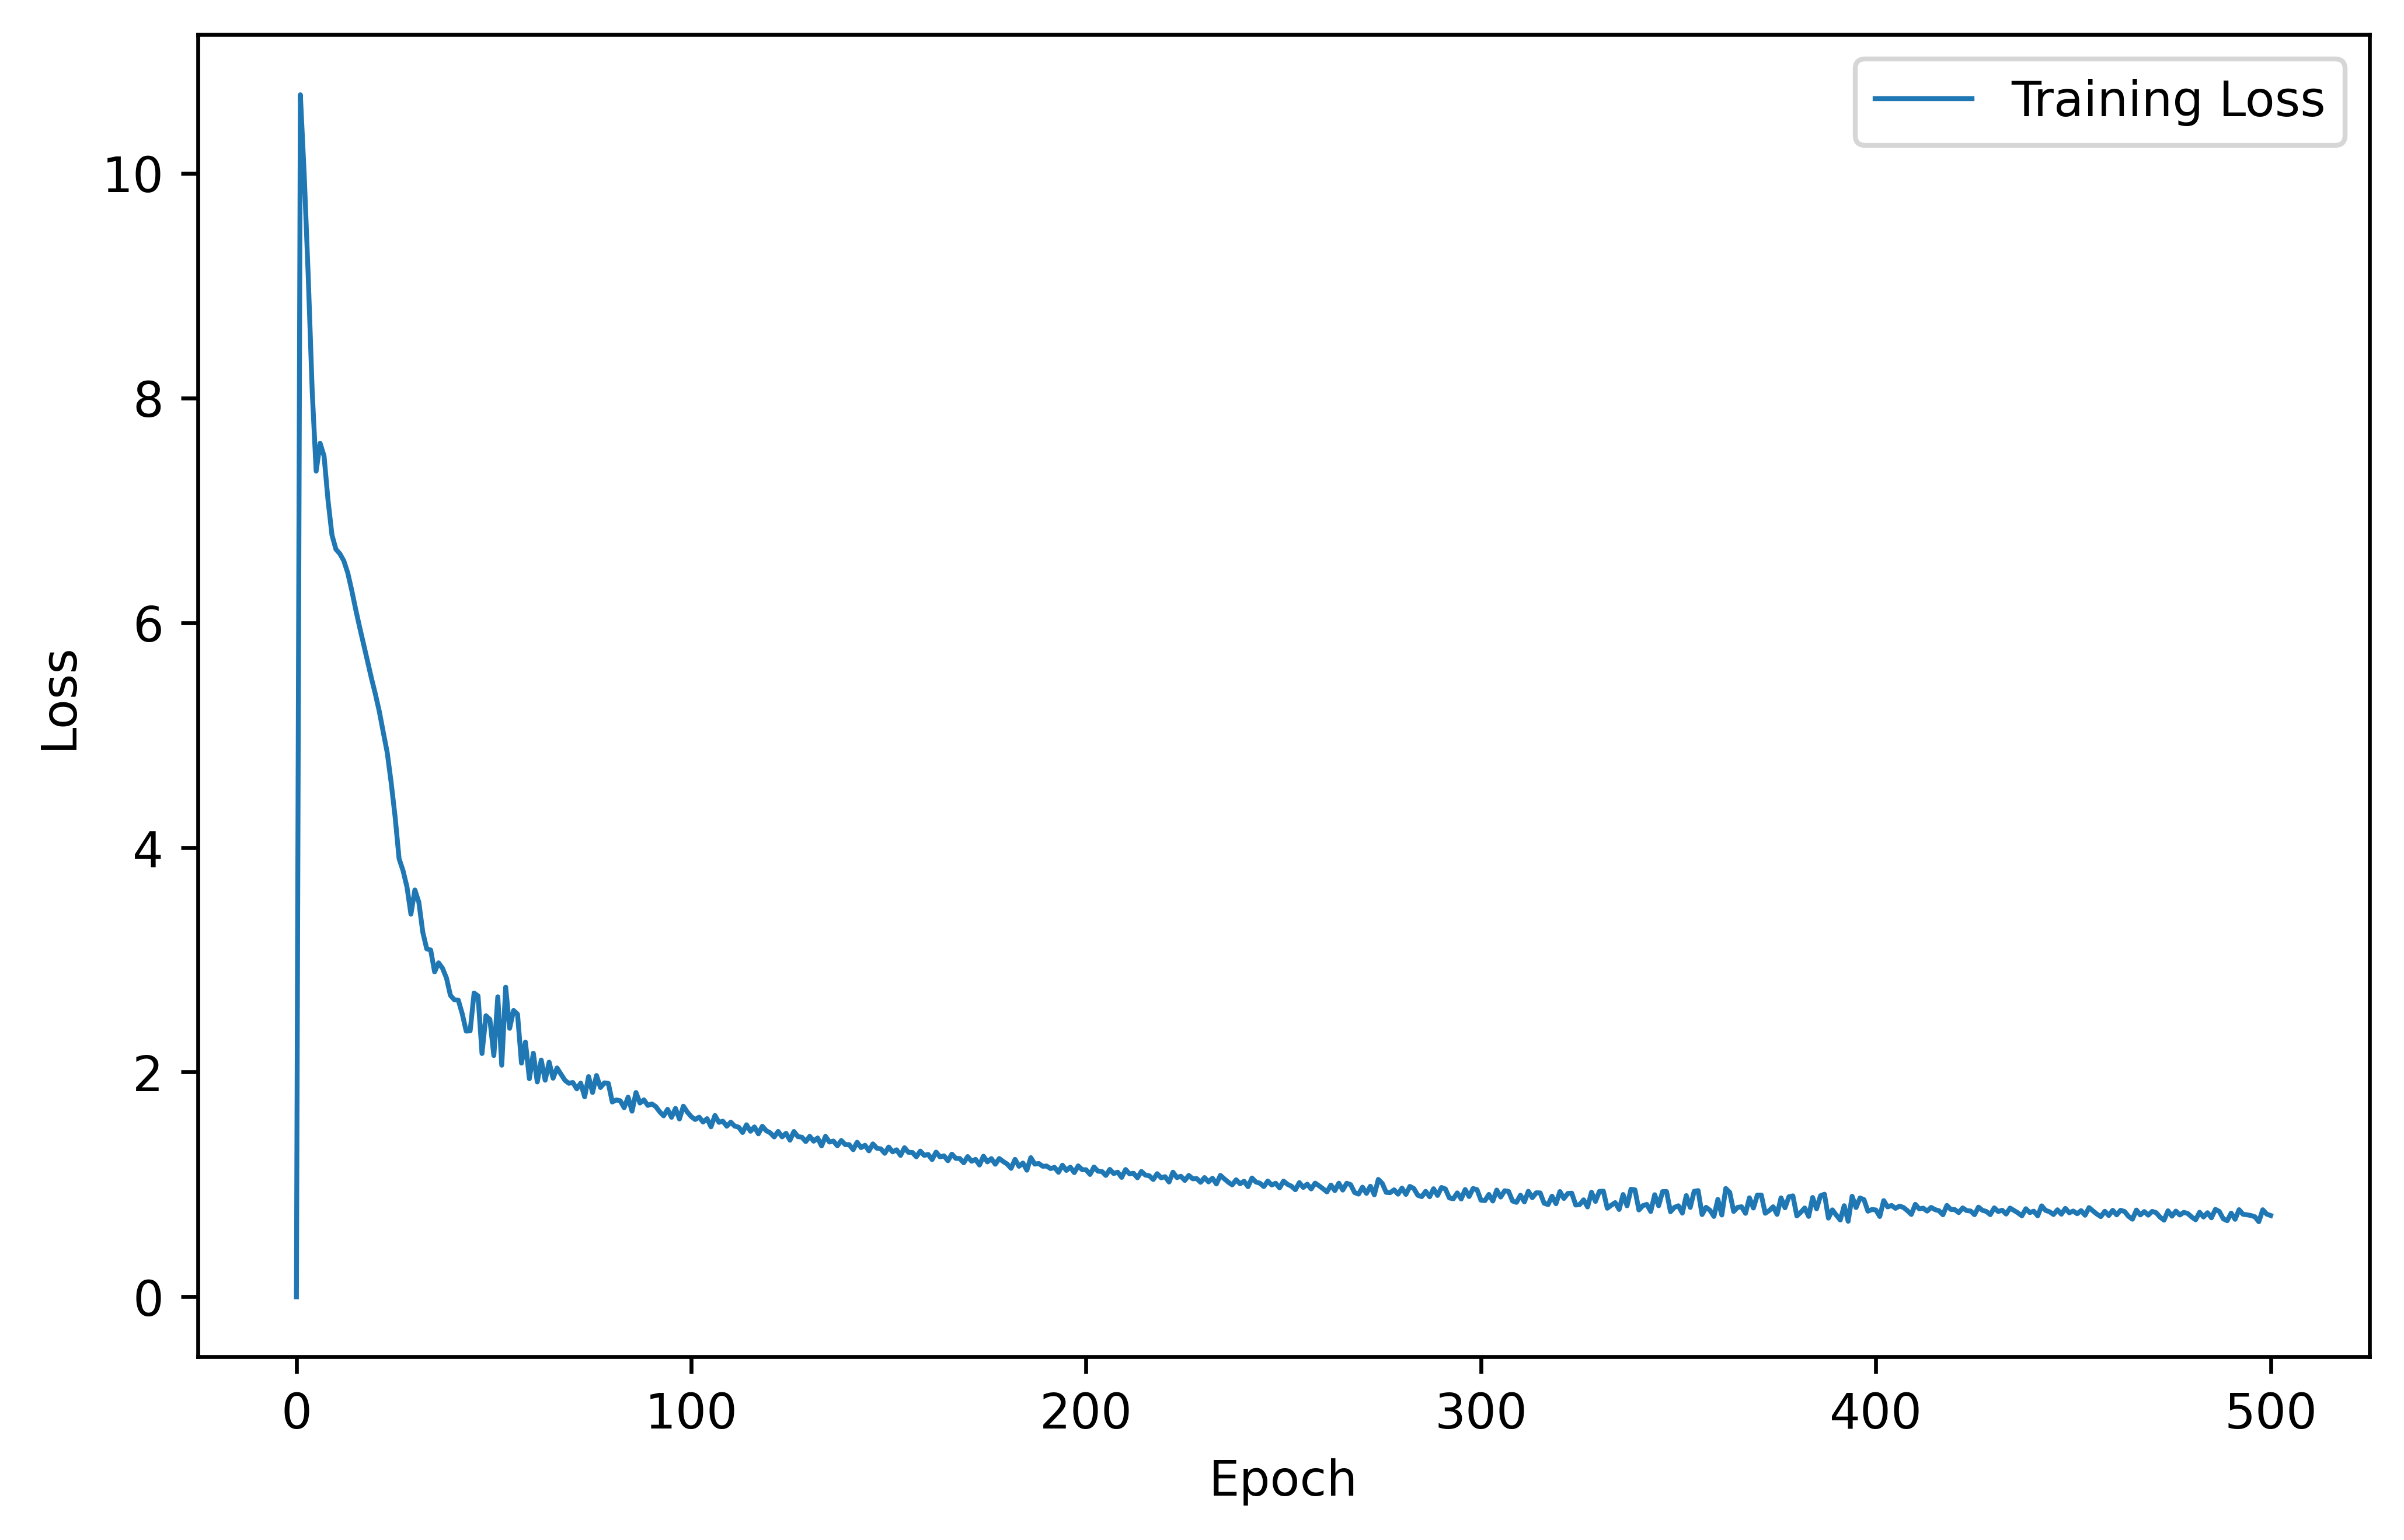

In [91]:
fig, ax1 = plt.subplots(figsize=(8, 5),dpi=600)
lns_TrainingLoss = ax1.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_loss_train,linewidth=1, linestyle='-', label="Training Loss")
label_TrainingLoss=["Training Loss"]
plt.legend(lns_TrainingLoss,label_TrainingLoss, loc=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'ACC')

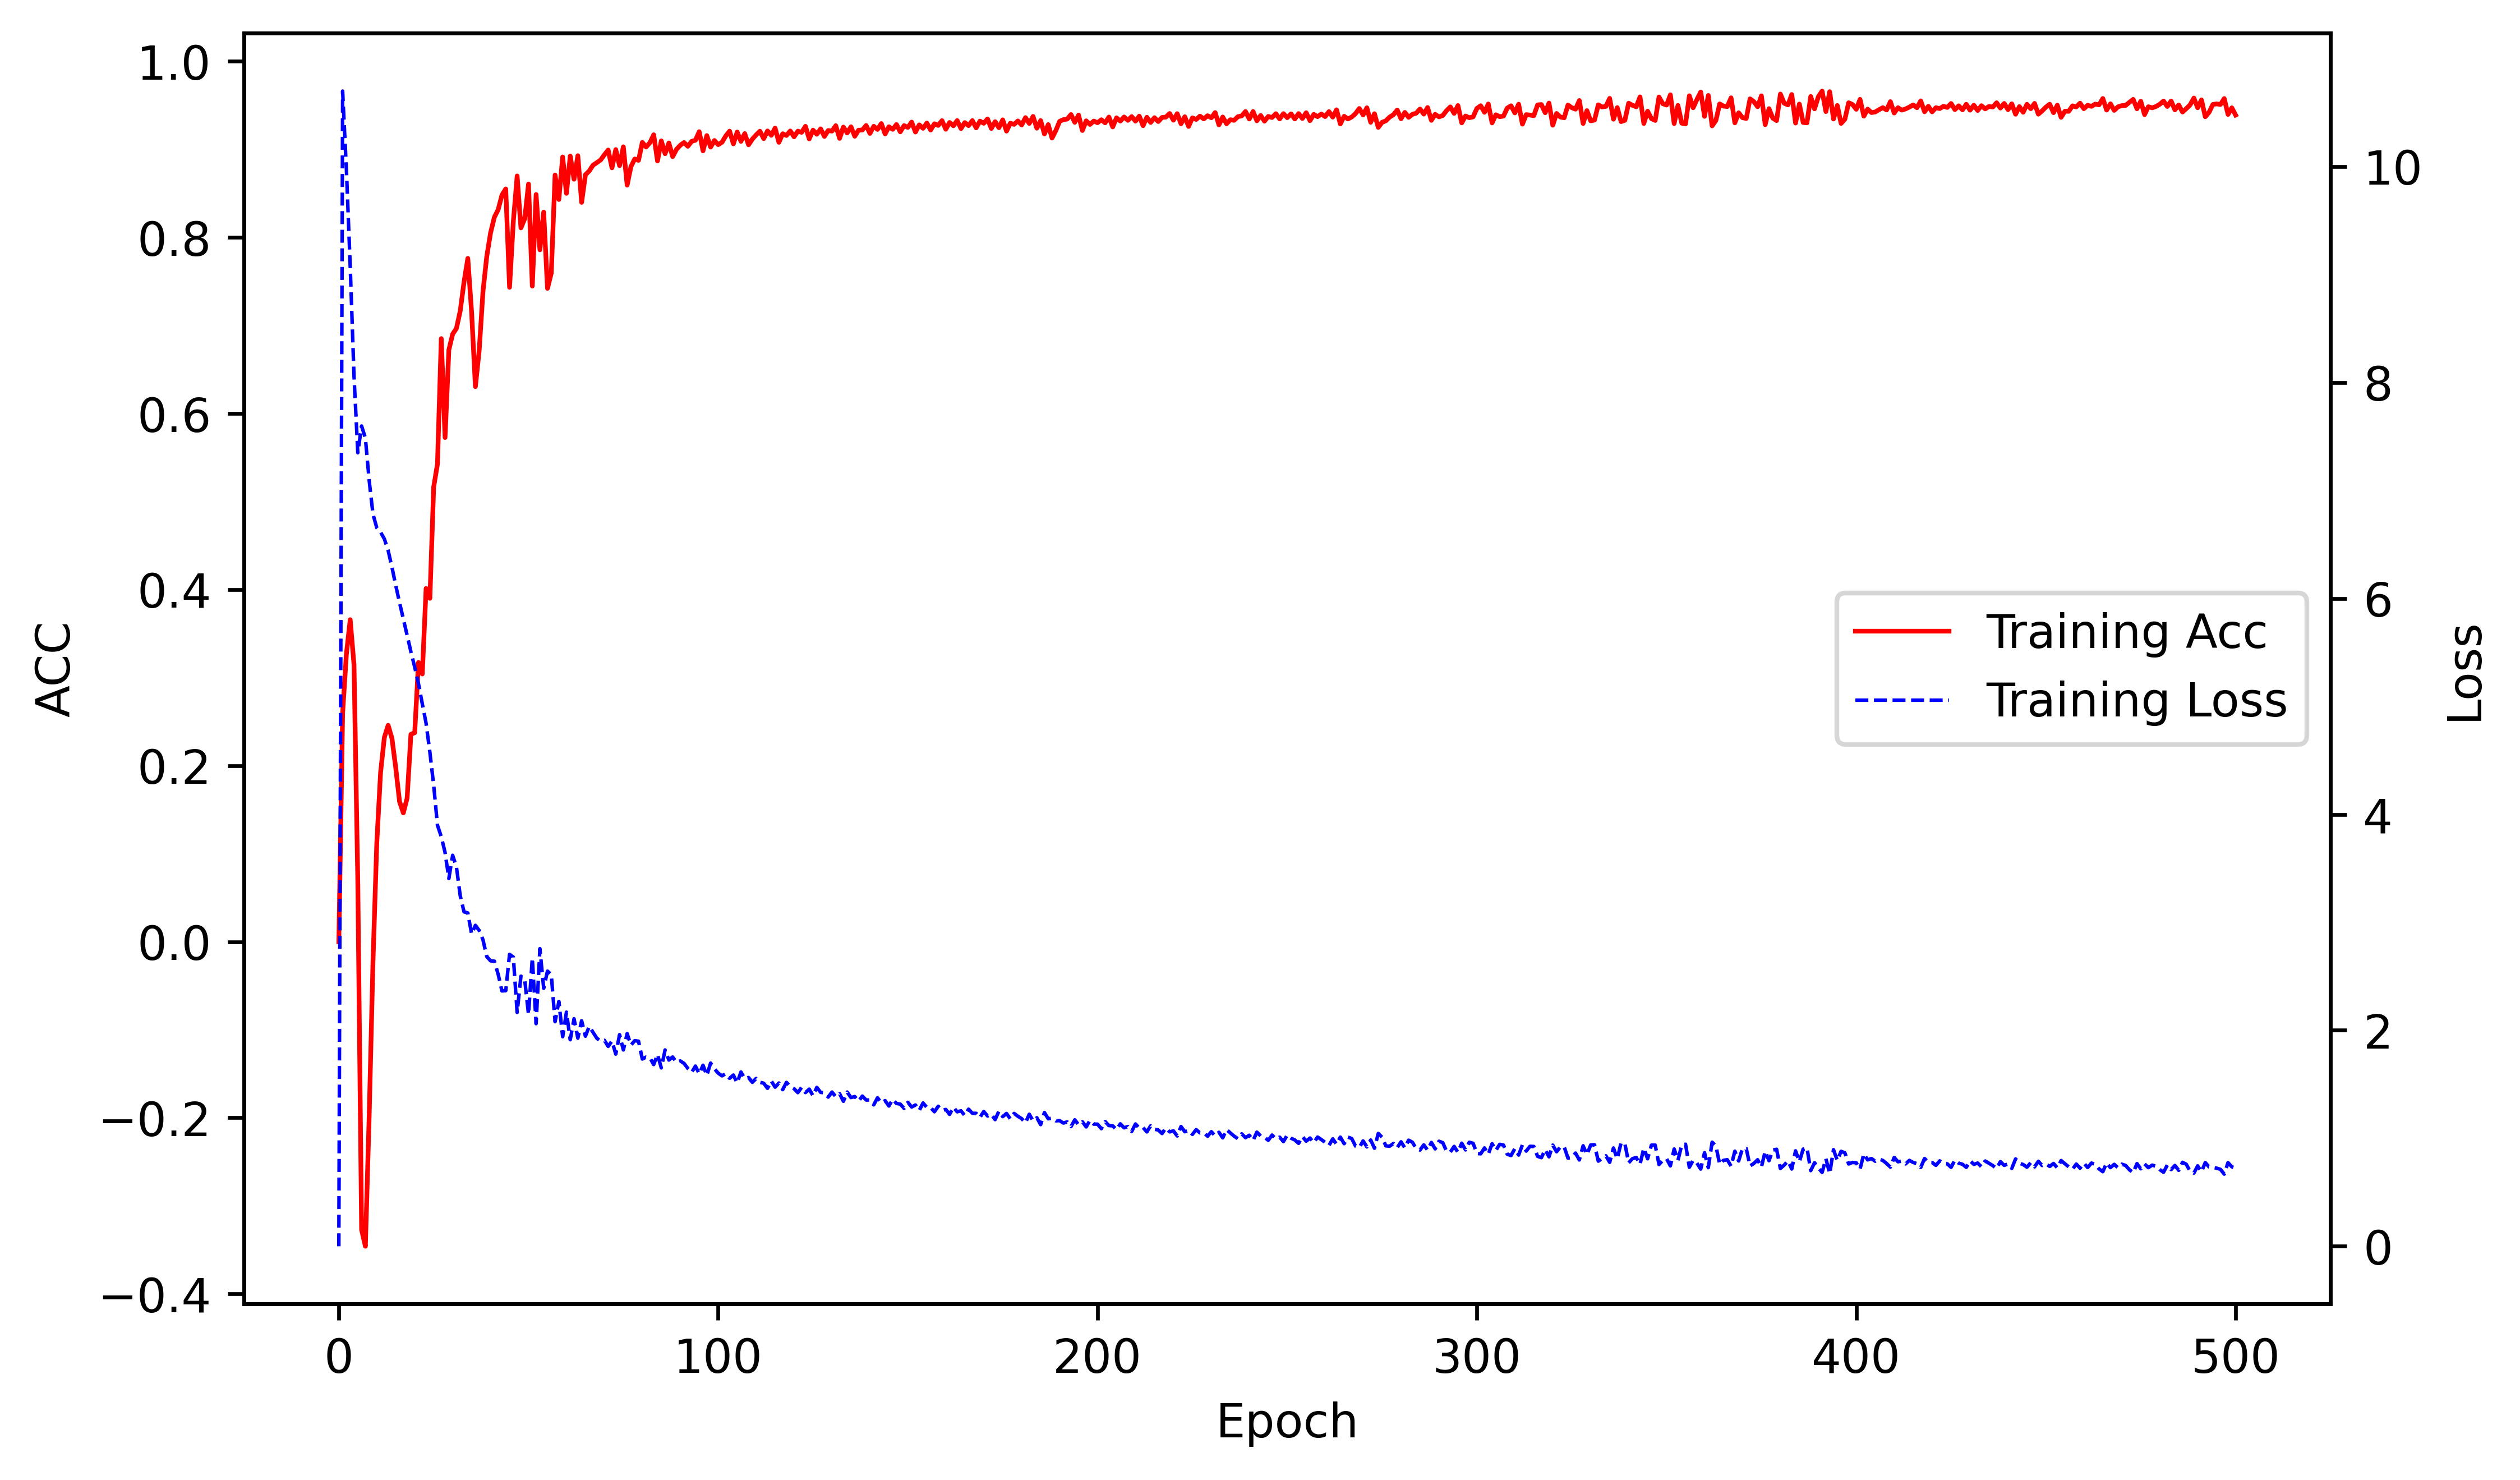

In [92]:
fig, ax1 = plt.subplots(figsize=(8, 5),dpi=600)
ax2 = ax1.twinx()
lns_TrainingAcc = ax1.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_acc_train, color='red', linewidth=1, linestyle='-', label="Training Acc")
lns_TrainingLoss=ax2.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_loss_train, color='blue', linewidth=0.75, linestyle='--', label="Training Loss")
lns_LossAcc=lns_TrainingAcc+lns_TrainingLoss
label_TrainingAcc=["Training Acc"]
label_TrainingLoss=["Training Loss"]
label_Acc=label_TrainingAcc+label_TrainingLoss
plt.legend(lns_LossAcc,label_Acc, loc=5)
ax1.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax1.set_ylabel('ACC')

Text(0, 0.5, 'RMSE')

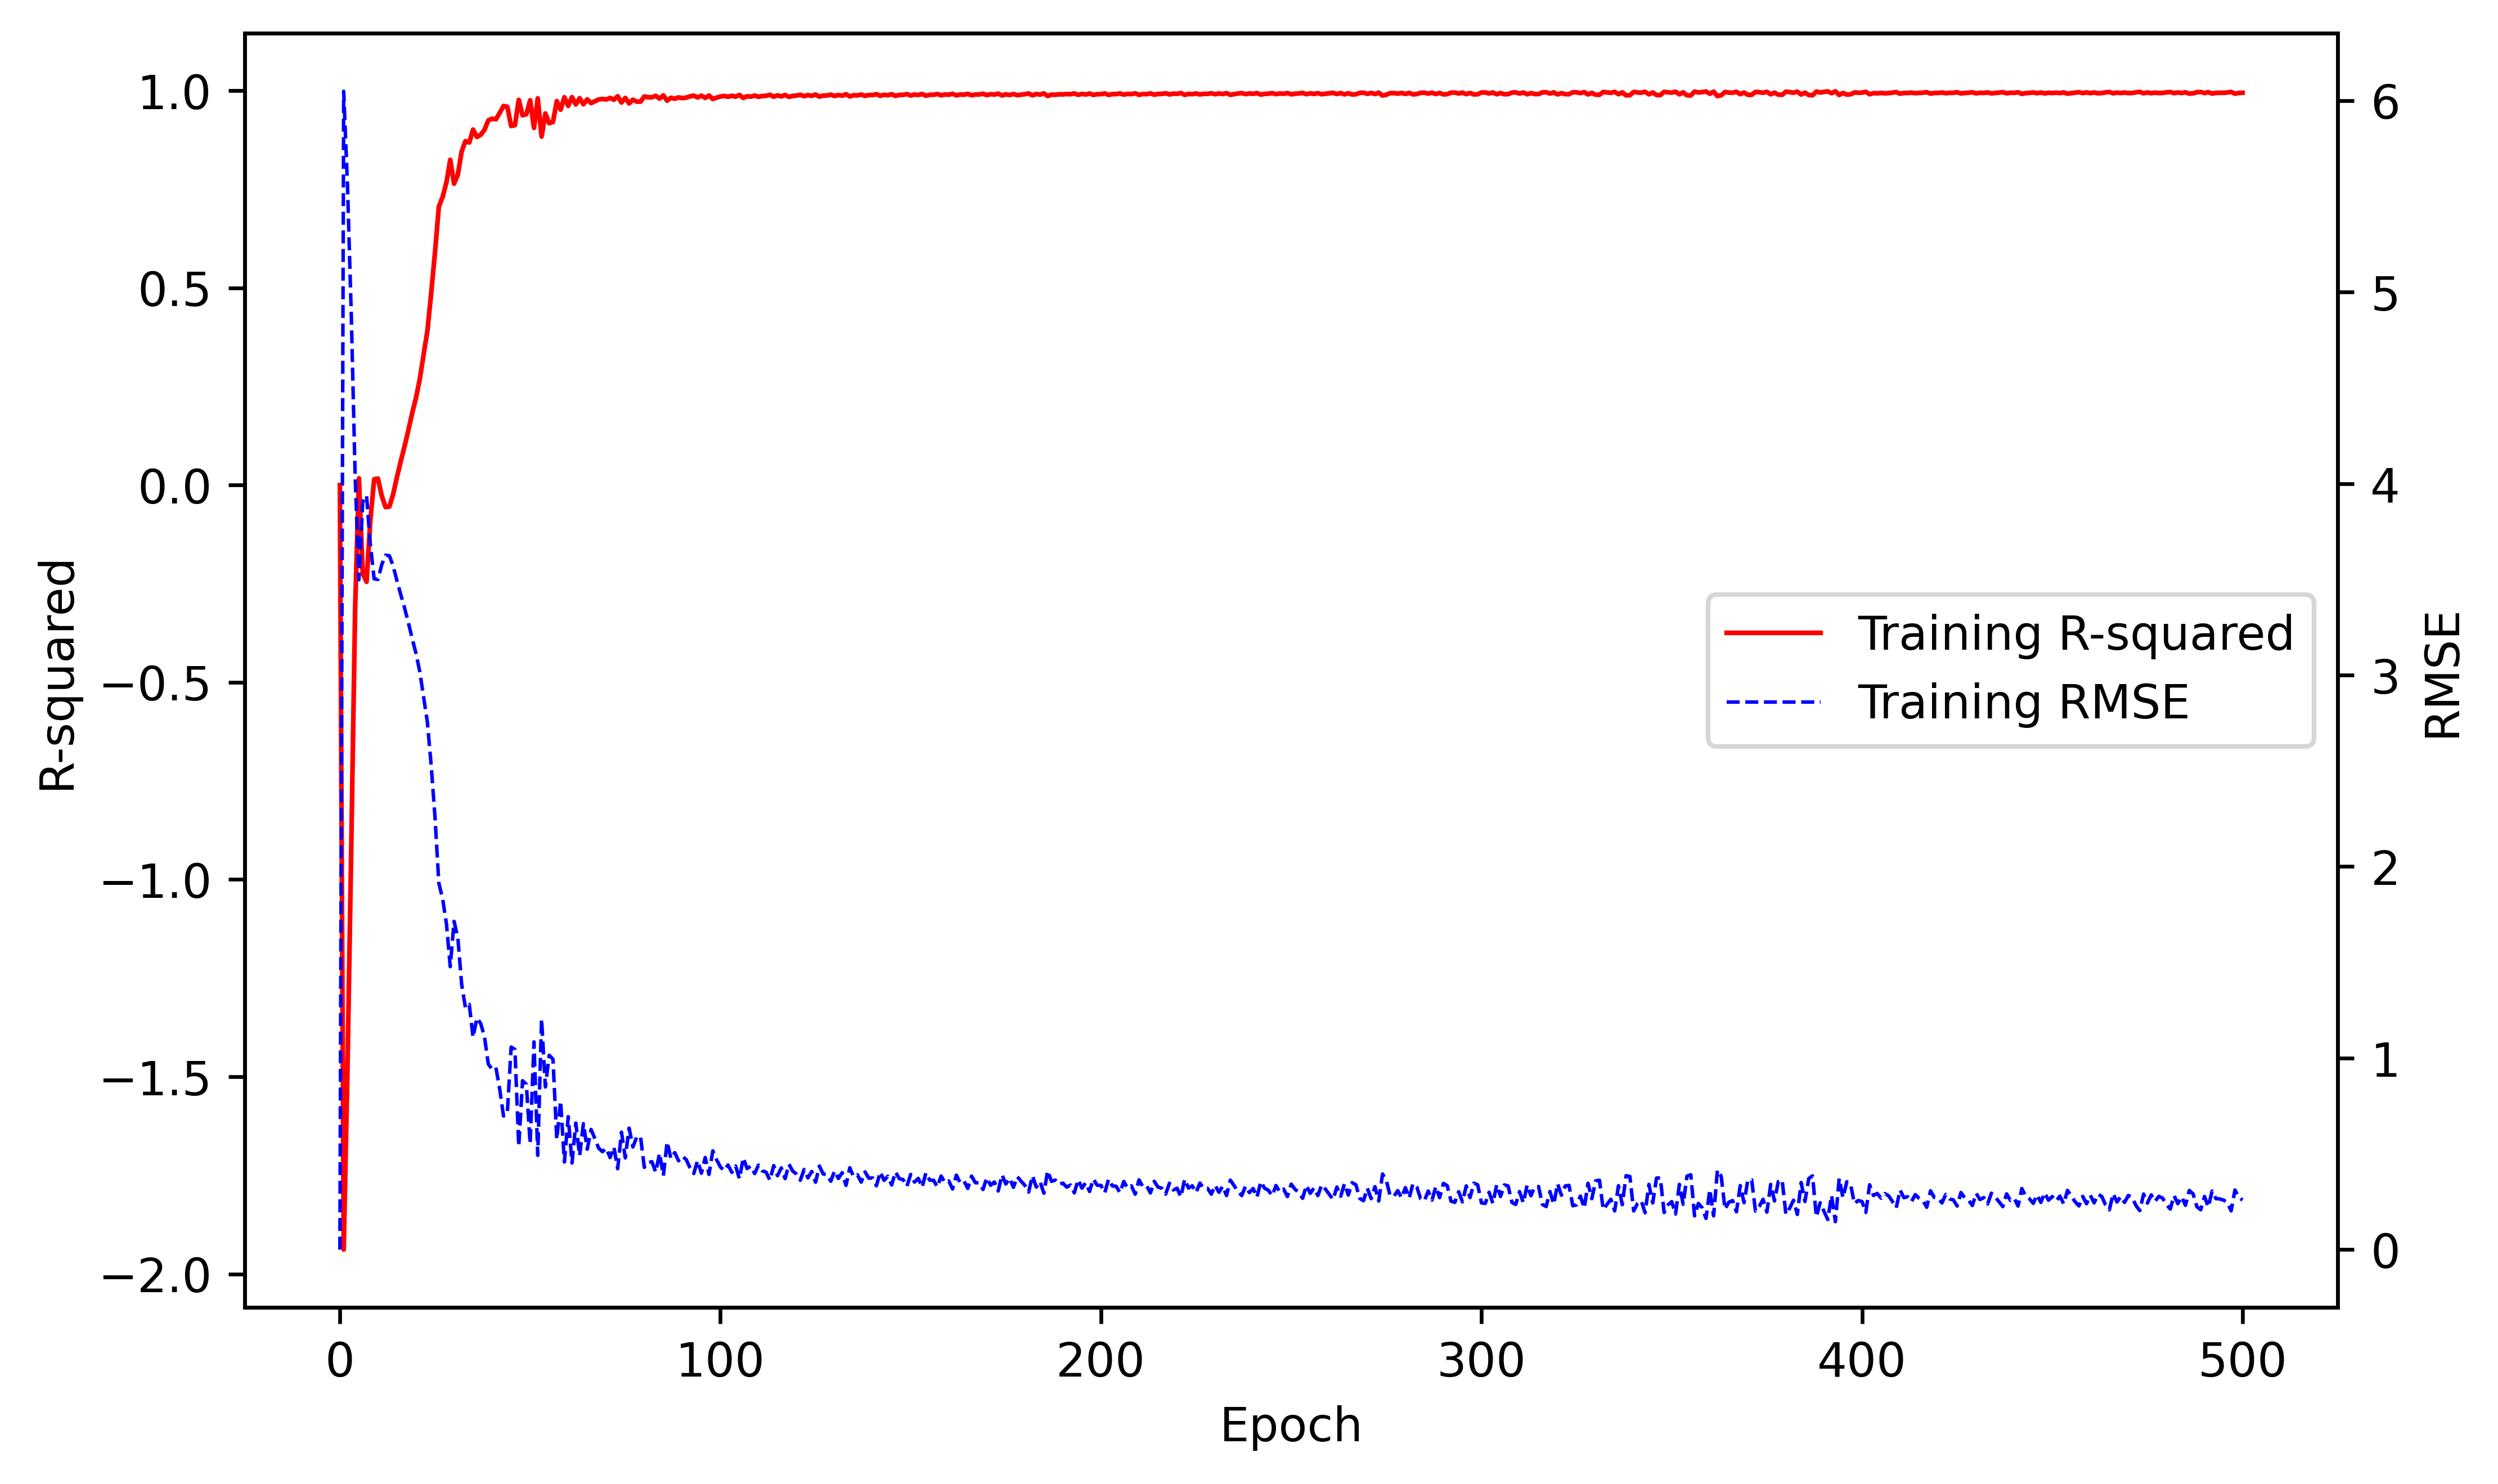

In [93]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(8, 5),dpi=600)
ax2 = ax1.twinx()
lns_TrainingR_squared = ax1.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_r_square_train, color='red', linewidth=1, linestyle='-', label="Training Acc")
lns_TrainingRMSE=ax2.plot(np.arange(int(np.ceil((max_iters+1) / interval))), fig_rmse_train, color='blue', linewidth=0.75, linestyle='--', label="Training RMSE")
# lns_TrainingR_squared = ax1.plot((np.arange(200)), fig_r_square_train[0:200], color='red', linewidth=1, linestyle='-', label="Training Acc")
# lns_TrainingRMSE=ax2.plot((np.arange(200)), fig_rmse_train[0:200], color='blue', linewidth=0.75, linestyle='--', label="Training RMSE")
lns_R_squaredRMSE=lns_TrainingAcc+lns_TrainingRMSE
label_TrainingR_squared=["Training R-squared"]
label_TrainingRMSE=["Training RMSE"]
label_R_squaredRMSE=label_TrainingR_squared+label_TrainingRMSE
plt.legend(lns_R_squaredRMSE,label_R_squaredRMSE, loc=5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('R-squared')
ax2.set_ylabel('RMSE')

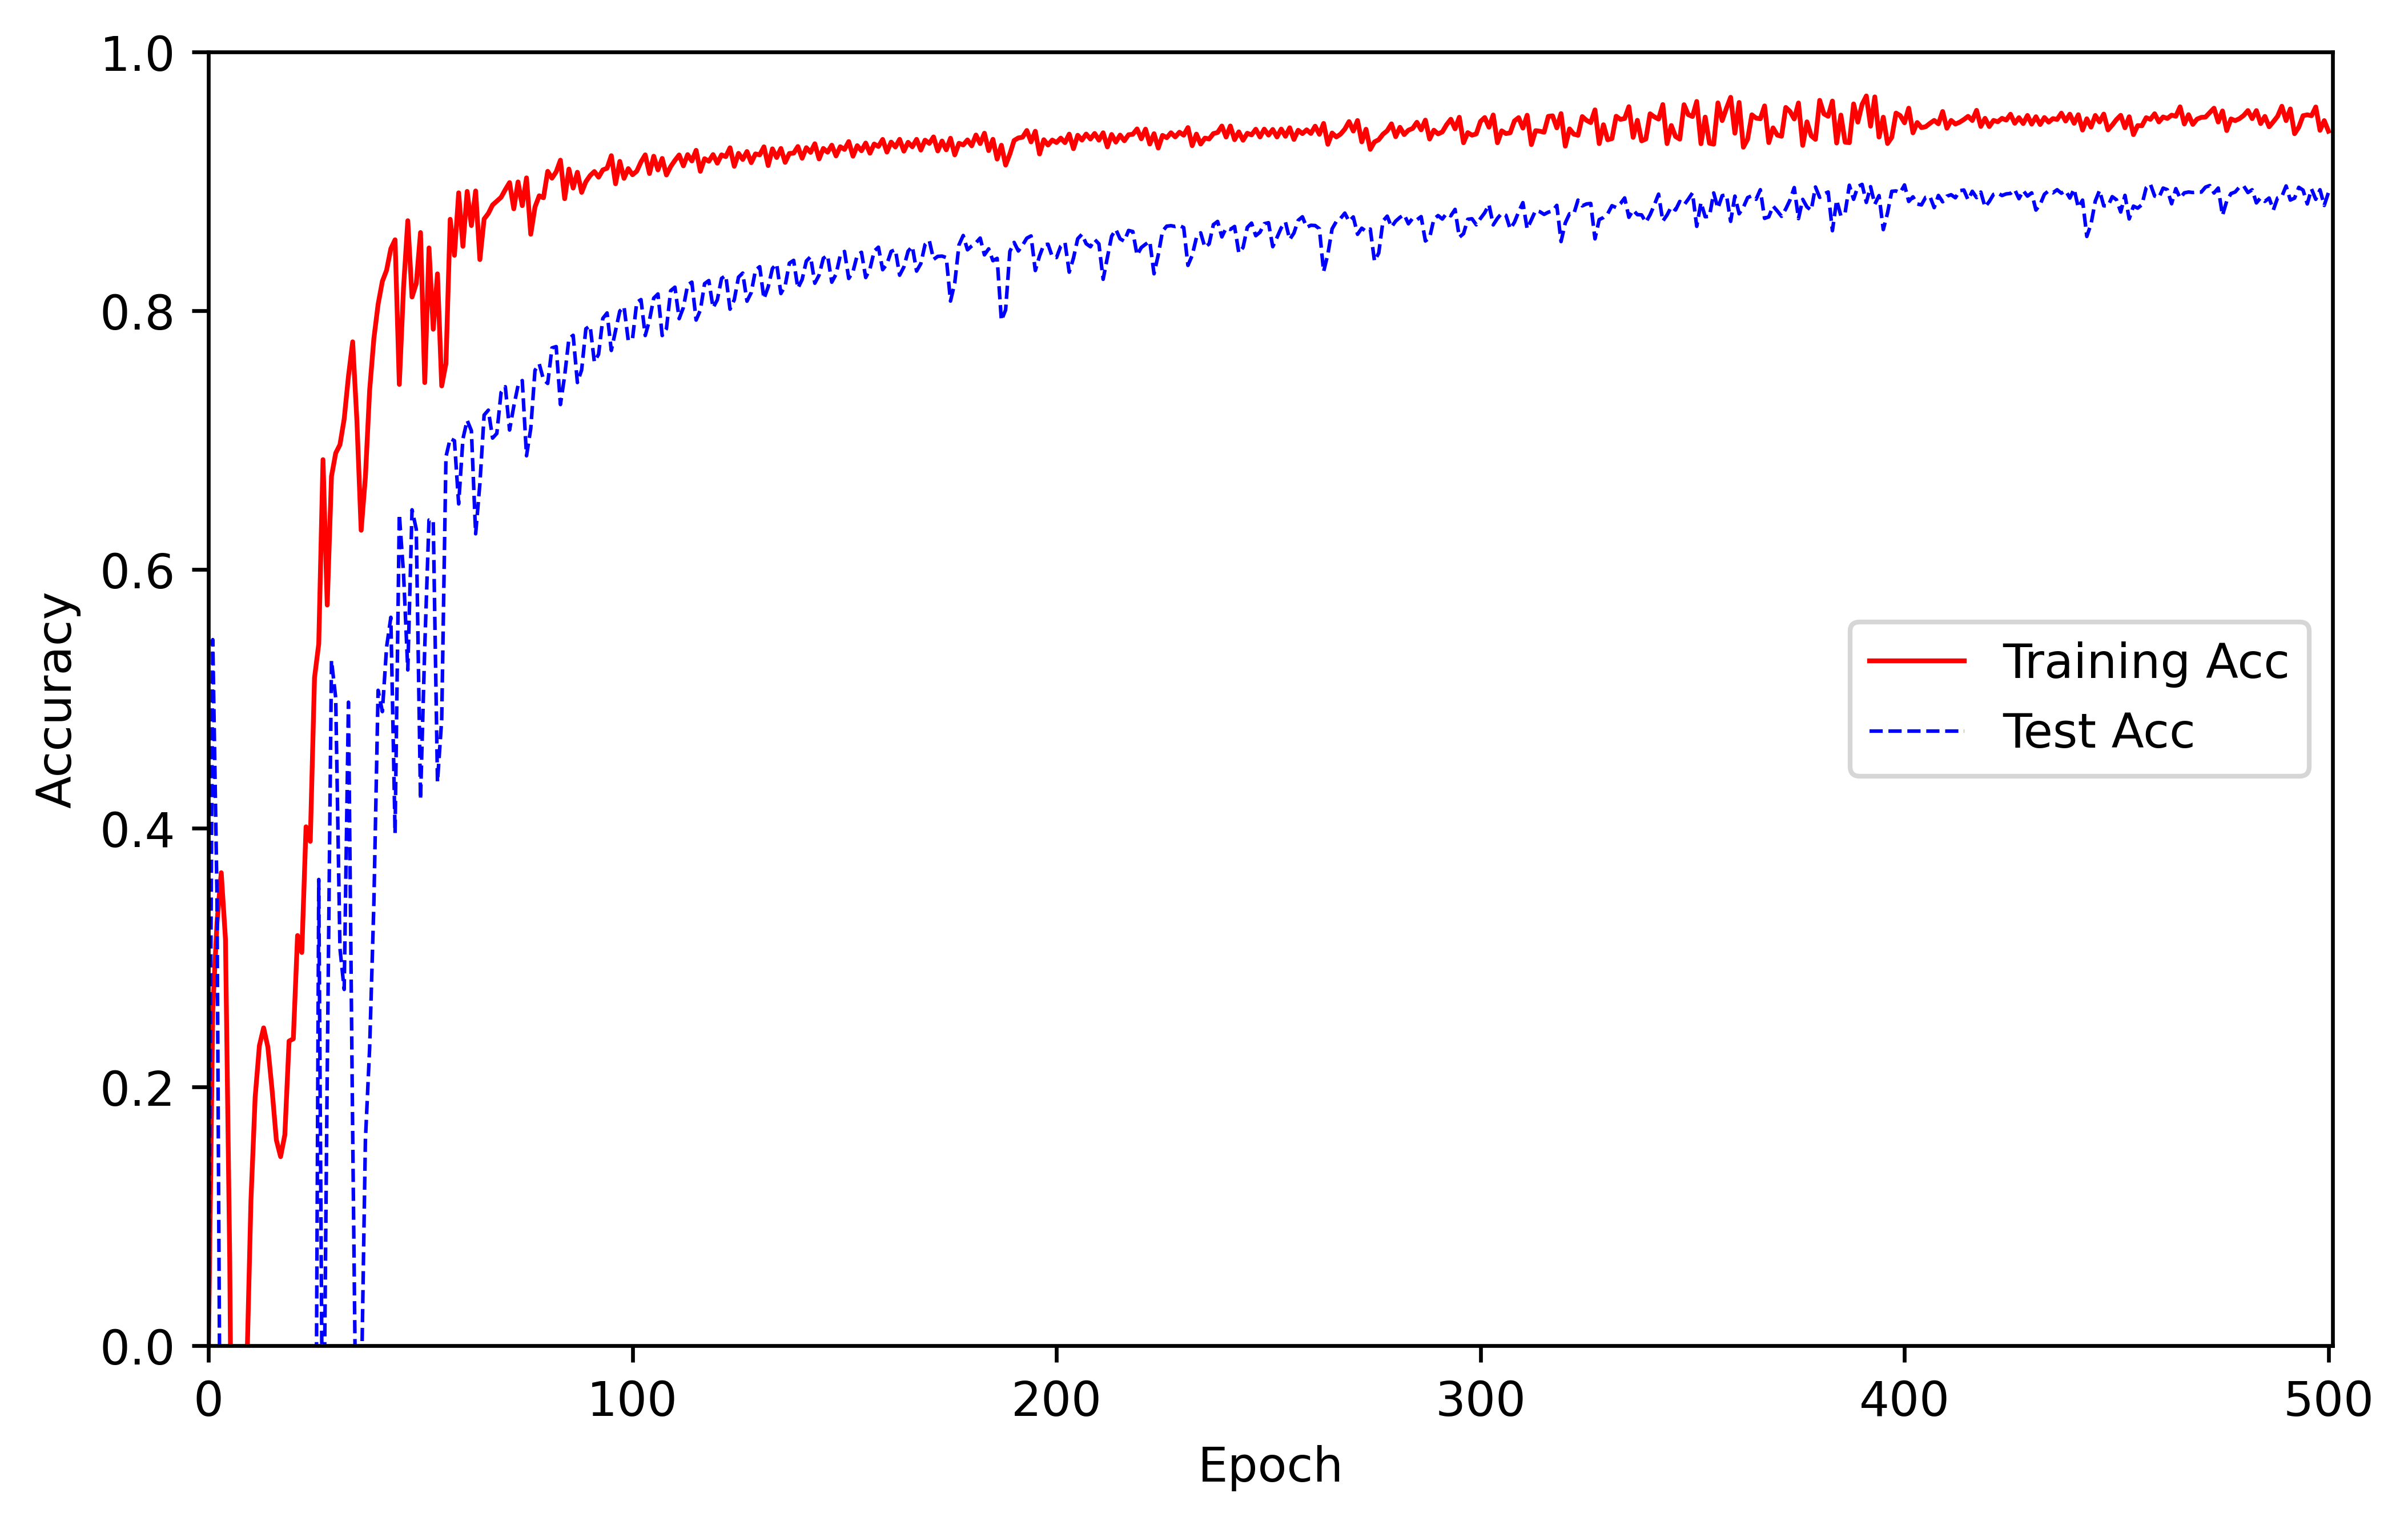

In [94]:
#创建数据
x = np.arange(int(np.ceil((max_iters+1) / interval)))
# x = np.arange(int(200))
y1 = fig_acc_train
y2 = fig_acc_test
#创建figure窗口
plt.figure(figsize=(8, 5),dpi=600)
#画曲线1
lns_TrainingAcc=plt.plot(x, y1, color='red', linewidth=1, linestyle='-', label="Train Acc")
#画曲线2
lns_TestAcc=plt.plot(x, y2, color='blue', linewidth=0.75, linestyle='--', label="Test Acc")
lns_Acc=lns_TrainingAcc+lns_TestAcc
label_TrainingAcc=["Training Acc"]
label_TestAcc=["Test Acc"]
label_Acc=label_TrainingAcc+label_TestAcc

#设置坐标轴范围
plt.xlim((0, 501))
plt.ylim((0, 1))
#设置坐标轴名称
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#设置坐标轴刻度
# my_x_ticks = np.arange(0, int(np.ceil((max_iters+1) / interval)), 25)
# my_y_ticks = np.arange(0, 1.2, 0.2)
# plt.xticks(my_x_ticks)
# plt.yticks(my_y_ticks)
label_Acc=label_TrainingAcc+label_TestAcc
plt.legend(lns_Acc,label_Acc, loc=5) 
#显示出所有设置

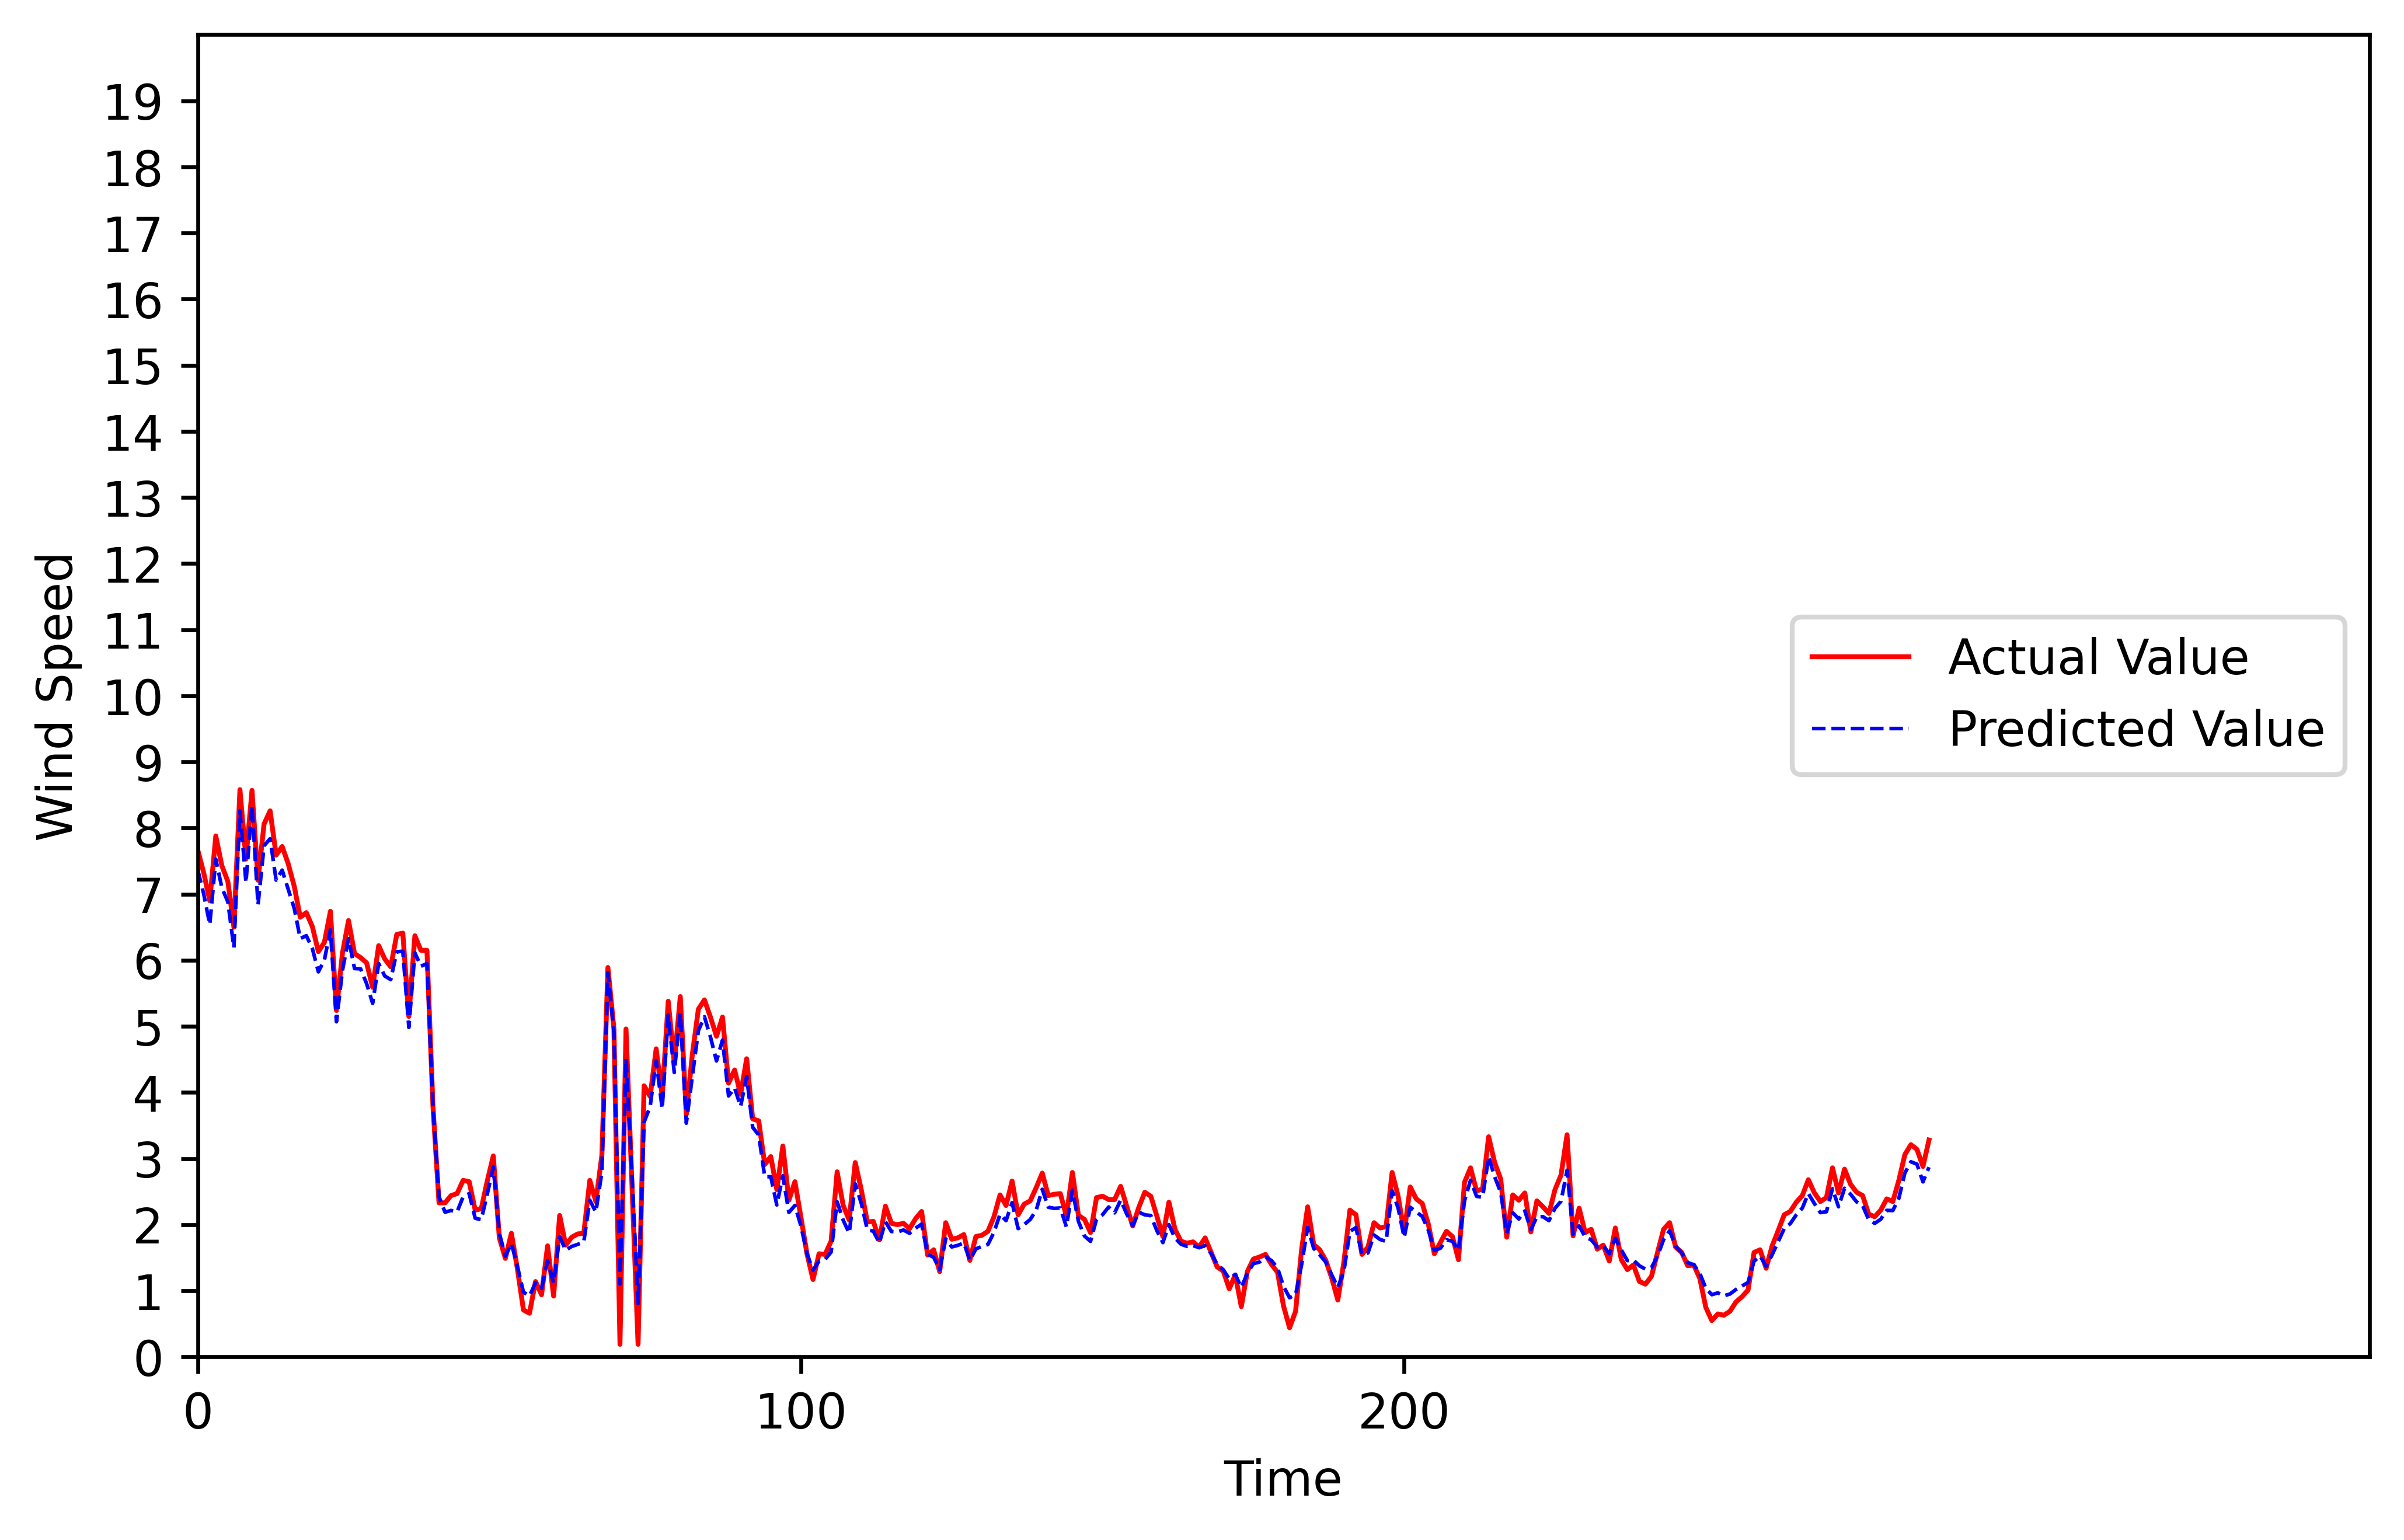

In [95]:
#创建数据
x = np.arange(len(fig_val))
y1 = fig_val
y2 = fig_prediction
#创建figure窗口
plt.figure(figsize=(8, 5),dpi=600)
#画曲线1
lns_ActualValue=plt.plot(x, y1, color='red', linewidth=1, linestyle='-', label="Actual Value")
#画曲线2
lns_PredictedValue=plt.plot(x, y2, color='blue', linewidth=0.75, linestyle='--', label="Predicted Value")
lns_ActualValuePredictedValue=lns_ActualValue+lns_PredictedValue
label_ActualValue=["Actual Value"]
label_PredictedValue=["Predicted Value"]
label_ActualValuePredictedValue=label_ActualValue+label_PredictedValue

#设置坐标轴范围
plt.xlim((0, 360))
plt.ylim((0, 20))
#设置坐标轴名称
plt.xlabel('Time')
plt.ylabel('Wind Speed')
#设置坐标轴刻度
my_x_ticks = np.arange(0, len(x), 100)
my_y_ticks = np.arange(0, 20, 1)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.legend(lns_ActualValuePredictedValue,label_ActualValuePredictedValue, loc=5) 

In [96]:
for i in range(len(fig_val)):
    print(fig_val[i][0])

7.67
7.32
6.9
7.88
7.43
7.19
6.5
8.58
7.53
8.57
7.21
8.06
8.26
7.59
7.72
7.46
7.12
6.65
6.72
6.51
6.13
6.27
6.74
5.24
6.11
6.6
6.1
6.04
5.96
5.59
6.22
6.02
5.9
6.39
6.41
5.15
6.37
6.15
6.15
3.79
2.33
2.33
2.44
2.47
2.67
2.65
2.22
2.24
2.66
3.04
1.8
1.49
1.87
1.33
0.71
0.66
1.14
0.94
1.68
0.92
2.14
1.69
1.81
1.86
1.87
2.67
2.35
3.05
5.89
4.96
0.19
4.96
2.5749999999999997
0.19
4.1
3.94
4.66
3.94
5.38
4.45
5.45
3.67
4.58
5.26
5.4
5.14
4.85
5.14
4.14
4.34
3.97
4.51
3.6
3.57
2.91
3.03
2.53
3.19
2.37
2.65
2.11
1.56
1.17
1.56
1.55
1.75
2.8
2.29
2.07
2.94
2.53
2.04
2.05
1.77
2.28
2.02
2.0
2.02
1.94
2.09
2.2
1.54
1.62
1.29
2.03
1.78
1.8
1.85
1.46
1.82
1.84
1.9
2.12
2.45
2.29
2.66
2.15
2.31
2.36
2.56
2.78
2.44
2.46
2.47
2.13
2.79
2.14
2.08
1.88
2.41
2.43
2.38
2.38
2.58
2.28
1.98
2.26
2.49
2.43
2.13
1.82
2.34
1.93
1.75
1.72
1.74
1.66
1.8
1.58
1.36
1.3
1.03
1.24
0.76
1.29
1.48
1.51
1.55
1.4
1.28
0.77
0.44
0.69
1.63
2.27
1.7
1.62
1.46
1.19
0.86
1.43
2.22
2.15
1.55
1.66
2.03
1.95
1.97
2.79
2.43
1.88

In [97]:
for i in range(len(fig_prediction)):
    print(fig_prediction[i][0])

7.3707414
7.0012426
6.5400014
7.5272484
7.0967045
6.882181
6.188965
8.258536
7.17521
8.345383
6.8363333
7.730582
7.837665
7.211669
7.3625746
7.075715
6.7860975
6.326912
6.371638
6.1794295
5.823981
6.0032496
6.4595823
5.068808
5.84877
6.324626
5.873897
5.8694296
5.6462655
5.3471336
5.949234
5.7617965
5.706309
6.126812
6.13688
4.982909
6.112873
5.9086018
5.948862
3.7797785
2.422281
2.1889772
2.2151556
2.194951
2.4219365
2.469554
2.0966623
2.0760632
2.4609542
2.8727622
1.8710941
1.5229156
1.7146144
1.3682754
0.9787148
0.9223311
1.1195452
1.0359764
1.4569294
1.1195422
1.8171251
1.6132327
1.6705801
1.7020907
1.7385447
2.3712544
2.1897764
2.7984095
5.8118763
4.9140215
1.1028512
4.511393
2.7510781
0.80714494
3.5521803
3.7844915
4.4792323
3.7532558
5.169153
4.30162
5.1974454
3.5350566
4.248216
4.934879
5.145274
4.83876
4.4761925
4.7926865
3.9467354
4.0684705
3.7888517
4.2414007
3.471624
3.3561606
2.724042
2.7259088
2.2984982
2.7401257
2.1851983
2.2906308
1.9804958
1.5619831
1.3118038
1.4491681